WASP 163 had some guidence issues, checking the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/'

In [6]:
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo25010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo25020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo25030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26040_sx1.fits'],
      dtype='<U67')

/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo25010_x1d.fits
G140L
131.97899


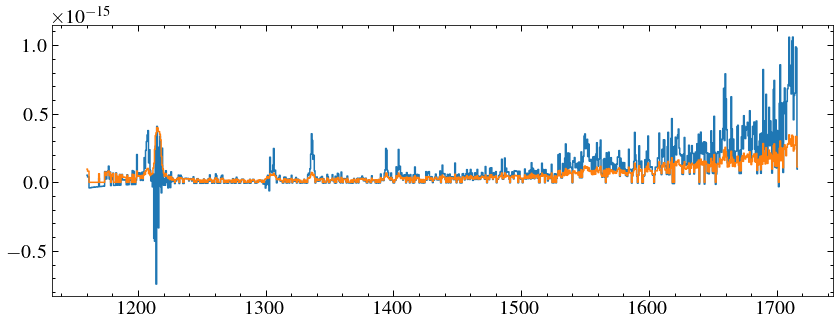

/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo25020_x1d.fits
G140L
132.22452


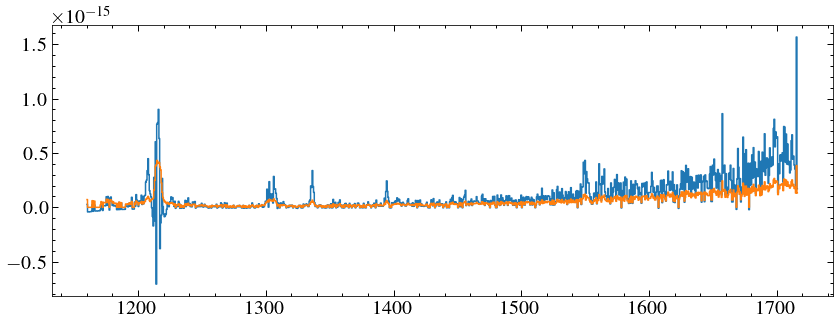

/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo25030_x1d.fits
G140L
132.36336


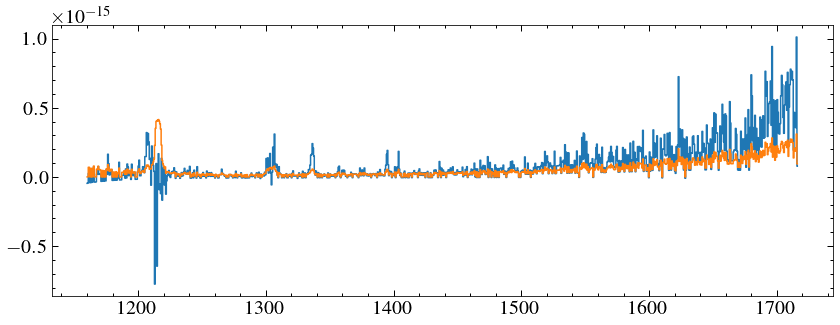

/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26010_x1d.fits
G140L
139.42422


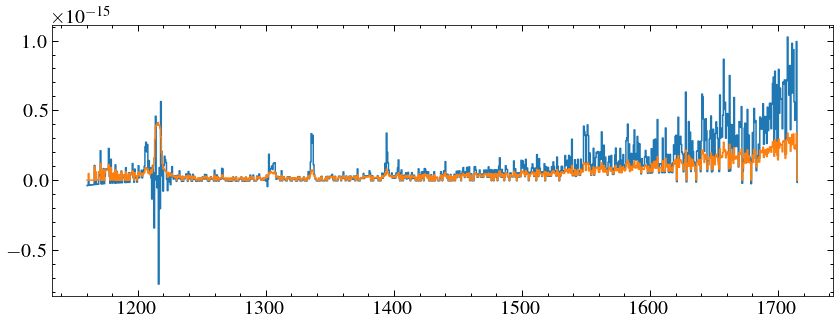

/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26020_x1d.fits
G140L
139.6578


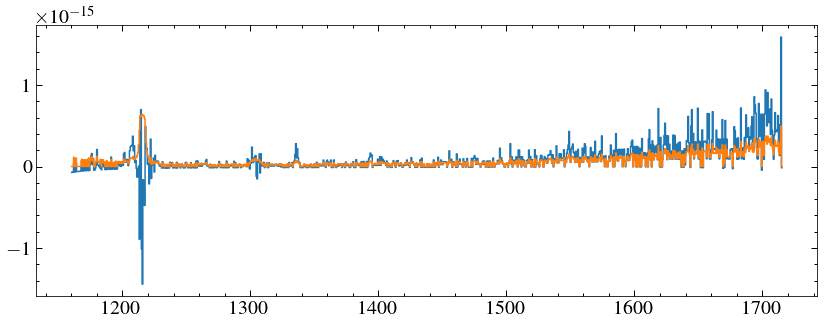

/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26030_x1d.fits
G230L
533.03766


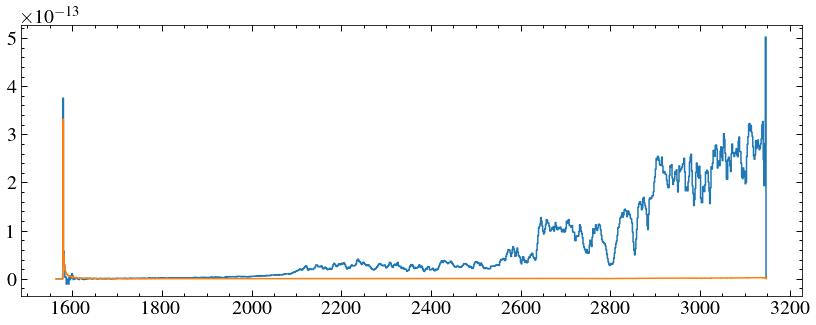

/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26040_sx1.fits
G430L
894.5721


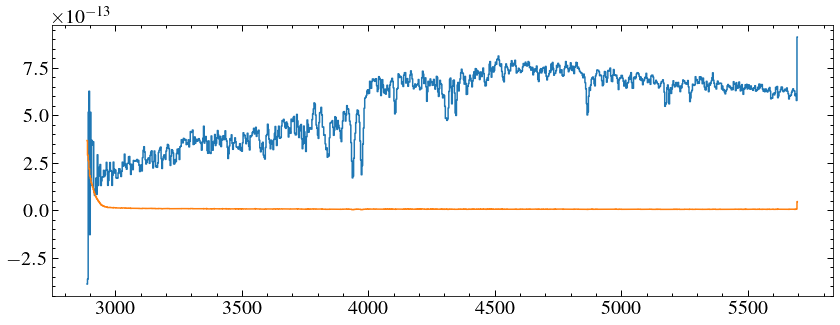

In [13]:
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    plt.show()
    

/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo25010_x1d.fits
G140L
131.97899
1024 1024 1024
0
0
957 957 957
/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo25020_x1d.fits
G140L
132.22452
1024 1024 1024
0
0
957 957 957
/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo25030_x1d.fits
G140L
132.36336
1024 1024 1024
0
0
957 957 957
/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26010_x1d.fits
G140L
139.42422
1024 1024 1024
0
0
955 955 955
/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26020_x1d.fits
G140L
139.6578
1024 1024 1024
0
0
955 955 955
/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26030_x1d.fits
G230L
533.03766
1024 1024 1024
0
0
1024 1024 1024
/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26040_sx1.fits
G430L
894.5721
1024 1024 1024
0
0
1024 1024 1024


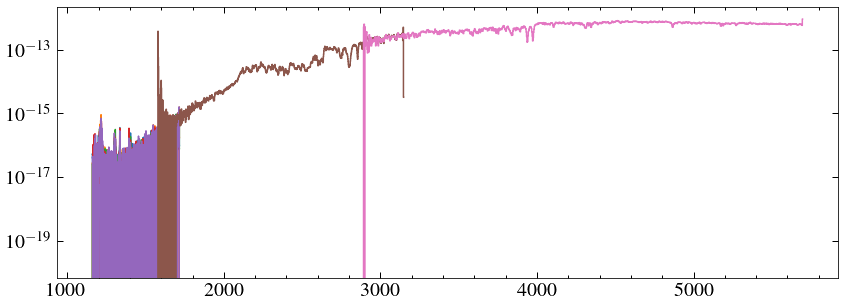

In [41]:
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    print(len(w), len(f), len(e))
    print(len(e[np.isnan(e)==True]))
    print(len(e[e< 0]))
    mask = w > 1160 
    w, f, e = w[mask], f[mask], e[mask]
    print(len(w), len(f), len(e))
    plt.step(w, f, where='mid')
    # plt.step(w, e, where='mid')
    # plt.show()
    plt.yscale('log')
    # plt.xscale('log')
    # plt.xlim(2800, 3200)

In [17]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

In [16]:
gratings = []
for x in x1ds:
    gratings.append(fits.getheader(x, 0)['OPT_ELEM'])
print(gratings)
    

['G140L', 'G140L', 'G140L', 'G140L', 'G140L', 'G230L', 'G430L']


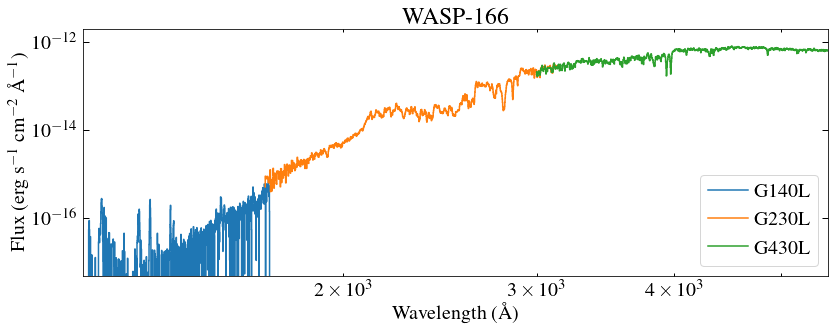

In [62]:
plt.figure(figsize=(12, 5))

f_fuv = []
e_fuv = []

n=0
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G140L':
        mask = (w > 1160)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_fuv = w
            f_fuv.append(f)
            e_fuv.append(e)
        else:
            f_fuv.append(interp1d(w, f, fill_value='extrapolate')(w_fuv))
            e_fuv.append(interp1d(w, e, fill_value='extrapolate')(w_fuv))            
        n +=1
    if grating == 'G230L':
        mask = (w > 1700) & (w <3130)
        w_nuv, f_nuv, e_nuv = w[mask], f[mask], e[mask]
    if grating == 'G430L':
        mask = (w > 3000) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]
        
f_fuv, e_fuv = spectra_adder(np.array(f_fuv), np.array(e_fuv), scale_correct=True)

plt.step(w_fuv, f_fuv, label='G140L')
plt.step(w_nuv, f_nuv, label='G230L')
plt.step(w_opt, f_opt, label='G430L')

plt.yscale('log')
plt.xscale('log')
plt.ylim(5e-18)
plt.xlim(1160, 5520)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
plt.title('WASP-166')
plt.tight_layout()
plt.savefig('plots/wasp166_ql.pdf')
plt.savefig('plots/wasp166_ql.png', facecolor='w')

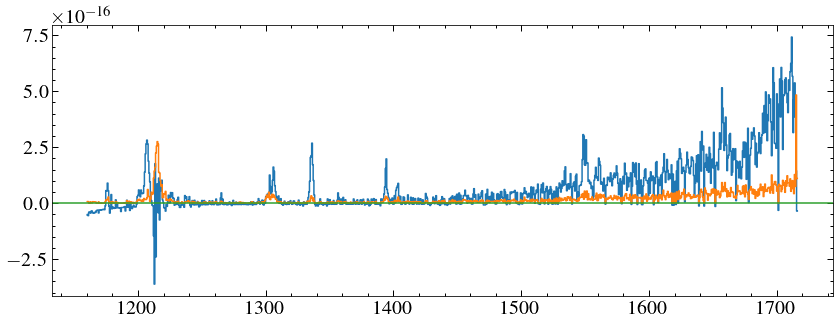

In [51]:
plt.step(w_fuv, f_fuv)
plt.step(w_fuv, e_fuv)
plt.axhline(0, c='C2')

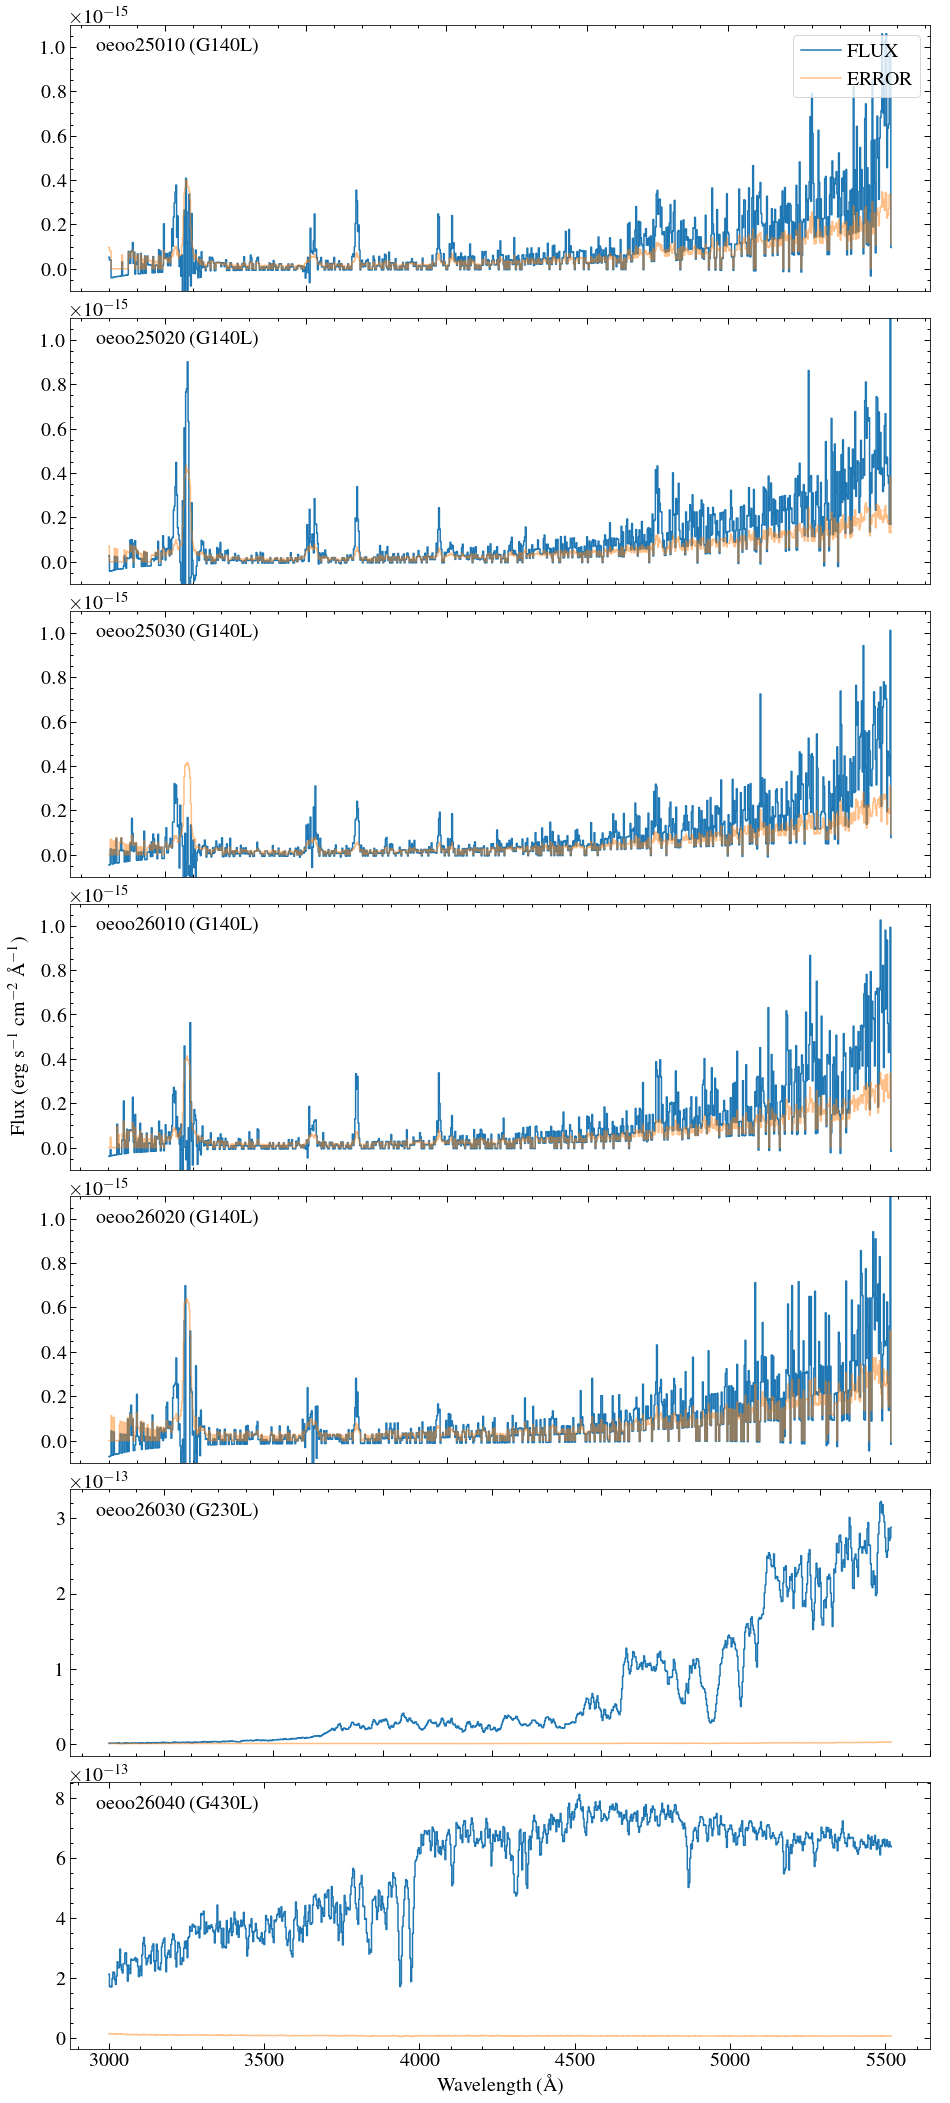

In [103]:
fig, axes = plt.subplots(figsize=(14, 30))

for i, x in enumerate(x1ds):
    plt.subplot(7,1,i+1)
    # print(x)
    # print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)[0]
    hdr = fits.getheader(x, 0)
    grating, root = hdr['OPT_ELEM'], hdr['ROOTNAME']
    # print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating == 'G140L':
        mask = (w > 1160)
        plt.ylim(-1e-16, 1.1e-15)
    if grating == 'G230L':
        mask = (w > 1700) & (w <3130)
    if grating == 'G430L':
        mask = (w > 3000) & (w <5520)
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', label='FLUX')
    plt.step(w, e, where='mid', alpha=0.5, label='ERROR')
    if i < len(x1ds)-1: 
        plt.xticks(visible=False)
    if i == 0:
        plt.legend(frameon=True, loc=)
    plt.annotate('{} ({})'.format(root, grating), (0.03, 0.95), xycoords='axes fraction', ha='left', va='top')
        
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20, labelpad=12)
plt.xlabel('Wavelength (\AA)')
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

plt.savefig('plots/wasp166_all_stis.pdf')
plt.savefig('plots/wasp166_all_stis.png', facecolor='w')
    # plt.show()
    

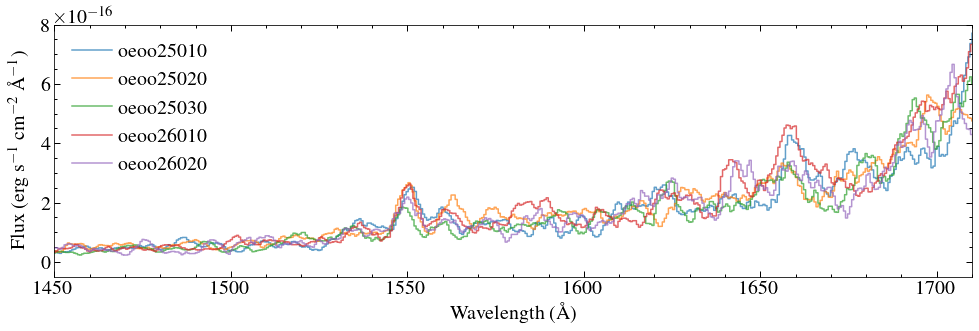

In [123]:
for i, x in enumerate(x1ds):
    # plt.subplot(7,1,i+1)
    # print(x)
    # print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)[0]
    hdr = fits.getheader(x, 0)
    grating, root = hdr['OPT_ELEM'], hdr['ROOTNAME']
    # print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating == 'G140L':
        mask = (w > 1160)
        w, f, e = w[mask], f[mask], e[mask]
        f = convolve(f,Box1DKernel(10))
        plt.step(w, f, where='mid', label=root, alpha=0.7)
    plt.ylim(-0.5e-16, 0.8e-15)
    plt.xlim(1450, 1710)
    plt.legend()
    # plt.title('WASP-166')
    plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20, labelpad=12)
    plt.xlabel('Wavelength (\AA)')
    plt.tight_layout()
    plt.savefig('plots/wasp166_g140l_cont.pdf')
    plt.savefig('plots/wasp166_g140l_cont.png', facecolor='w')
    # plt.yscale('log')

Quick diagnosis for FUV glow - row 200 of flts

In [125]:
flts = glob.glob('{}*flt.fits'.format(path))
flts

['/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo25010_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo25020_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo25030_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26010_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26020_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26030_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/wasp166/oeoo26040_flt.fits']

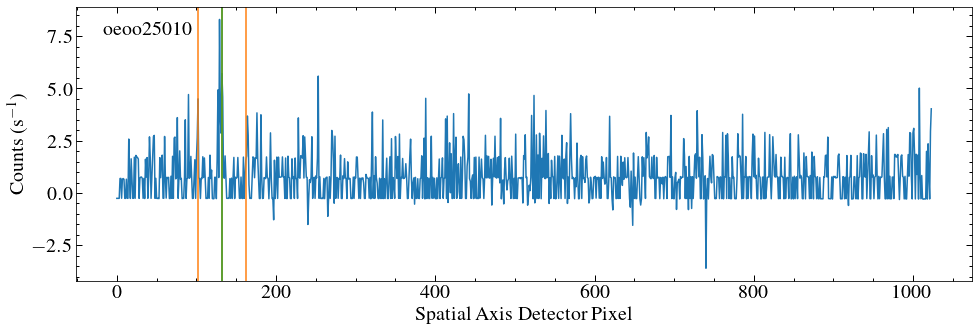

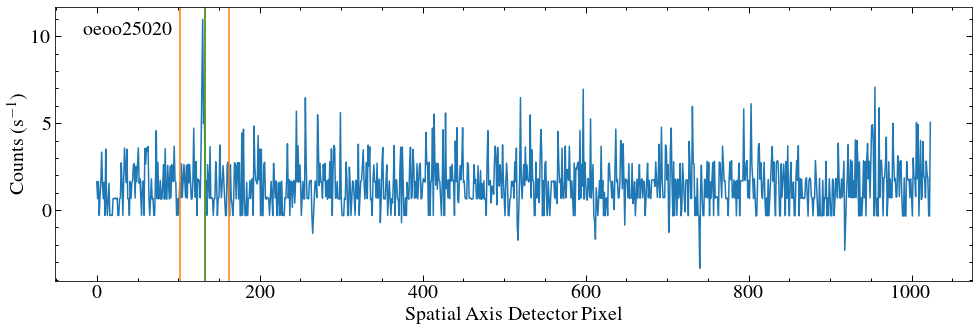

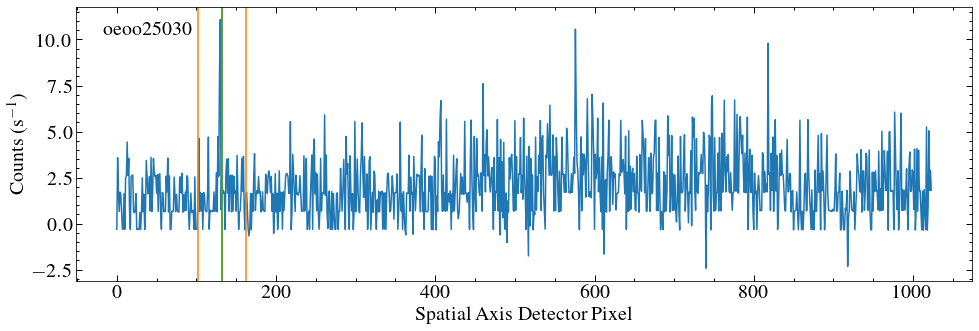

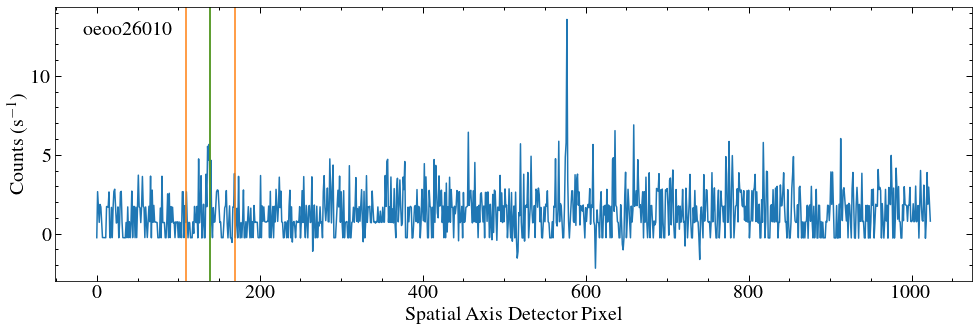

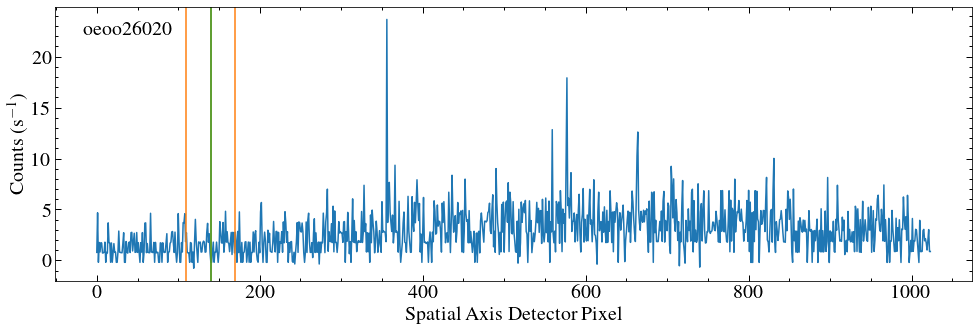

In [163]:
checkrow = 200
for flt in flts:
    hdr = fits.getheader(flt, 0)
    grating, root = hdr['OPT_ELEM'], hdr['ROOTNAME']
    if grating == 'G140L':        
        data = fits.getdata(flt, 1)
        data = np.transpose(data) #flip the image to make the next row more simple
        data = data[checkrow-10:checkrow+10]
        data = np.sum(data, axis=0)
        plt.plot(np.arange(len(data)), data)
        
        spec = fits.getdata('{}{}_x1d.fits'.format(path, root))[0]
        [plt.axvline(line, c='C1') for line in (spec['A2CENTER'], spec['A2CENTER']+spec['BK1OFFST'], spec['A2CENTER']+spec['BK2OFFST'])]
        plt.axvline(spec['A2CENTER'], c='C2')      
        plt.ylabel('Counts (s$^{-1}$)')
        plt.xlabel('Spatial Axis Detector Pixel')
        plt.annotate('{}'.format(root), (0.03, 0.95), xycoords='axes fraction', ha='left', va='top')
        plt.tight_layout()
        plt.show()

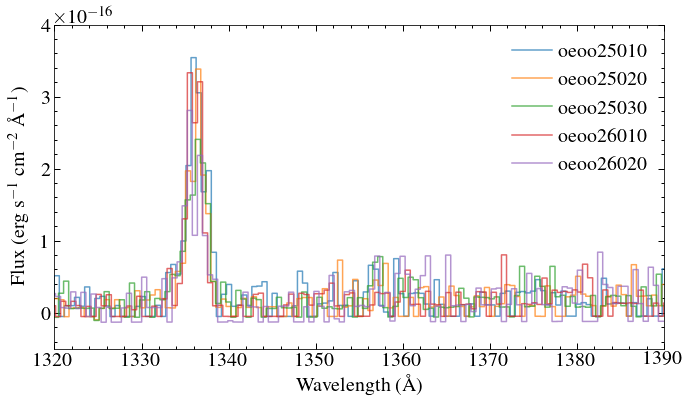

In [171]:
plt.figure(figsize=(10, 6))
for i, x in enumerate(x1ds):
    # plt.subplot(7,1,i+1)
    # print(x)
    # print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)[0]
    hdr = fits.getheader(x, 0)
    grating, root = hdr['OPT_ELEM'], hdr['ROOTNAME']
    # print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating == 'G140L':
        mask = (w > 1160)
        w, f, e = w[mask], f[mask], e[mask]
        # f = convolve(f,Box1DKernel(10))
        plt.step(w, f, where='mid', label=root, alpha=0.7)
    plt.ylim(-0.5e-16, 0.4e-15)
    plt.xlim(1320, 1390)
    plt.legend()
    # plt.title('WASP-166')
    plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20, labelpad=12)
    plt.xlabel('Wavelength (\AA)')
    plt.tight_layout()
    # plt.savefig('plots/wasp166_g140l_cont.pdf')
    # plt.savefig('plots/wasp166_g140l_cont.png', facecolor='w')
    # plt.yscale('log')